# **2 Data Source**
Our dataset originates from the ISIC (International Skin Imaging Collaboration), a collaborative effort that focuses on skin imaging. Specifically, the dataset was published in 2019 and includes eight distinct categories of skin diseases. It is a substantial collection, featuring over 20,000 images in the widely-used JPG format. Additionally, the dataset is accompanied by a CSV file containing the corresponding labels for each image in a one-hot encoded format, which facilitates their classification and analysis. This comprehensive resource is an invaluable tool for researchers and practitioners in dermatology and the broader field of medical imaging.

Although the website mentions a relevant test dataset, it is currently inaccessible. Consequently, we have divided the available dataset into three parts, designated as the training set, validation set, and test set, to ensure a robust framework for model development and evaluation.


https://challenge.isic-archive.com/data/#2019


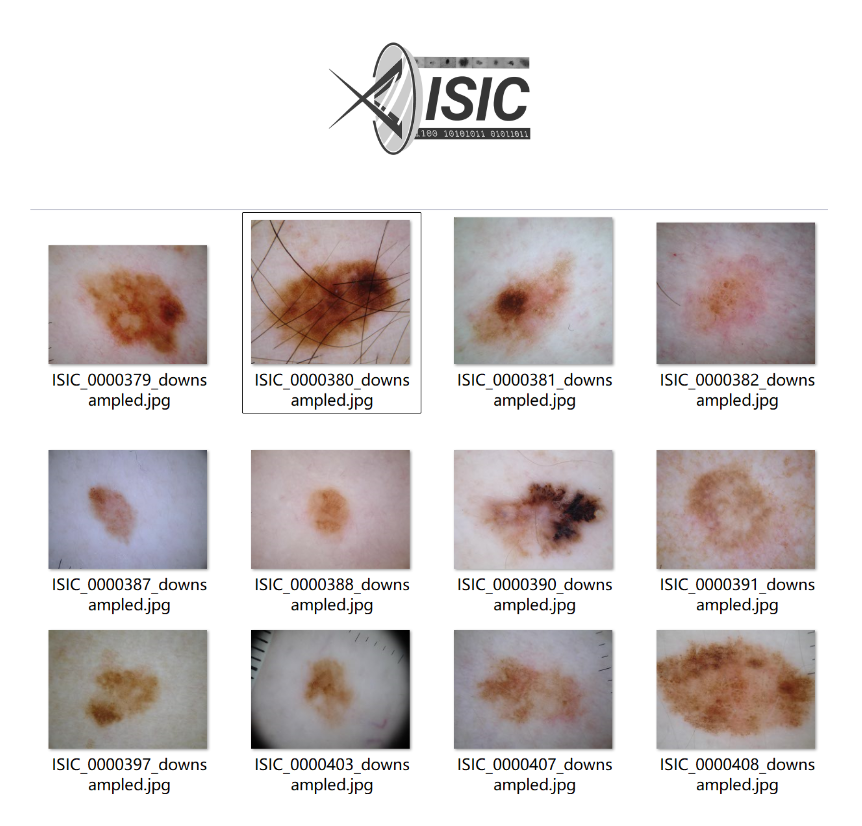

## **2.1 Original Dataset**
The following code demonstrates a data preprocessing pipeline for a skin disease classification task using PyTorch. It begins by importing necessary libraries, including pandas for data manipulation and torch for building the dataset. The dataset, stored in a CSV file, contains image filenames and corresponding labels. These are read into a DataFrame and split into training, validation, and testing sets with a ratio of 0.6:0.2:0.2. The training and validation sets are split from the training data to ensure balanced data distribution.

The code defines a custom PyTorch dataset class, SkinDiseaseDataset, which is responsible for loading images and applying transformations. Images are resized to 224x224 and normalized using predefined mean and standard deviation values. The DataLoader is used to create iterable datasets for training, validation, and testing, enabling efficient data loading during model training. This setup facilitates the use of data augmentation and transformation techniques to improve model generalization.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify the file paths here
csv_file_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
image_files = data['image'].values
labels = data.drop(['image', 'UNK'], axis=1).values

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

# Define a custom dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training, validation, and testing datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir = image_folder_path, transform=transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir = image_folder_path, transform=transform)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir = image_folder_path, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Test
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print(train_dataset[0])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


15198
5066
5067
(tensor([[[-1.9295, -1.8268, -1.6898,  ..., -1.5014, -1.4843, -1.4672],
         [-1.8782, -1.7583, -1.6384,  ..., -1.5357, -1.5185, -1.5014],
         [-1.8097, -1.6898, -1.5699,  ..., -1.5528, -1.5357, -1.5014],
         ...,
         [-1.3644, -1.3644, -1.3815,  ..., -1.9638, -1.9638, -1.9638],
         [-1.3473, -1.3644, -1.3815,  ..., -1.9638, -1.9638, -1.9809],
         [-1.3473, -1.3473, -1.3815,  ..., -1.9638, -1.9638, -1.9809]],

        [[-1.9482, -1.8957, -1.7906,  ..., -1.7206, -1.7031, -1.6856],
         [-1.9132, -1.8431, -1.7381,  ..., -1.7206, -1.7031, -1.6856],
         [-1.8782, -1.8081, -1.6681,  ..., -1.7206, -1.7031, -1.7381],
         ...,
         [-1.6331, -1.6331, -1.6506,  ..., -1.9832, -2.0007, -2.0007],
         [-1.6155, -1.6331, -1.6331,  ..., -1.9832, -2.0007, -2.0182],
         [-1.6155, -1.6331, -1.6331,  ..., -1.9832, -2.0007, -2.0182]],

        [[-1.5779, -1.4559, -1.3339,  ..., -1.3339, -1.3339, -1.3164],
         [-1.5081, -1.4036, 

# **3 Analysis of Data**
After obtaining the quantity of images for each skin disease, we found that our dataset is highly imbalanced. Therefore, we employed data augmentation and under-sampling to balance it.


In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_GroundTruth.csv')

df = df.drop(columns=['image'])
for col in df.columns:
    df[col] = df[col].astype(int)

disease_counts_series = df.loc[:, df.columns != 'UNK'].sum()

# Convert the sum results to integer type
disease_counts = disease_counts_series.astype(int)
disease_counts = disease_counts.rename("Count")

total_count = df.sum().sum()

# Add the Total as a new row to the disease_counts
disease_counts.loc['Total'] = total_count

# Set the disease names as the index
disease_counts.index.name = "Diseases"

# Print the statistics directly
print(disease_counts)

Diseases
MEL       4522
NV       12875
BCC       3323
AK         867
BKL       2624
DF         239
VASC       253
SCC        628
Total    25331
Name: Count, dtype: int64


In our dataset, there is a column labeled "UNK" which contains no images. Therefore, we have removed this column, leaving us with a total of eight skin disease categories.


The original dataset analysis reveals a significant class imbalance, with the 'NV' (Nevi) category having the highest count at 12,875 instances, which is considerably higher than the other skin disease categories. For instance, 'MEL' (Melanoma) has 4,522 instances, 'BCC' (Basal Cell Carcinoma) has 3,323, and 'SCC' (Squamous Cell Carcinoma) has 628. The least represented categories are 'DF' (Dermatofibroma) with only 239 instances and 'VASC' (Vascular) with 253.


To address this imbalance, we will employ undersampling for the 'NV' class to reduce its representation in the training set. This technique will help prevent the model from becoming biased towards the majority class. For the other categories with fewer instances, we will apply data augmentation to artificially increase their numbers and improve the model's ability to generalize.


However, it is important to maintain the original distribution of data in the validation and test datasets. This approach ensures that the model is evaluated on data that reflects the real-world scenario, including the prevalence of each skin disease category. The balancing efforts are strictly for the training dataset to enhance model performance and fairness in learning from all classes equally.

## **3.1 Some attempts**
We tried many data augmentation techniques, such as artifact removal, specifically hair removal in images, color correction, illumination correction, edge enhancement, and so on. The hair removal effect was good, as shown below. However, the issue was that it took too much time, like one minute per image, and we have more than 20,000 images. So, we consulted our tutor, and he told us that we didn't need to do this part. As a result, we removed this part and switched to some simpler data augmentation methods, like random flipping, random cropping, and changing contrast, etc.


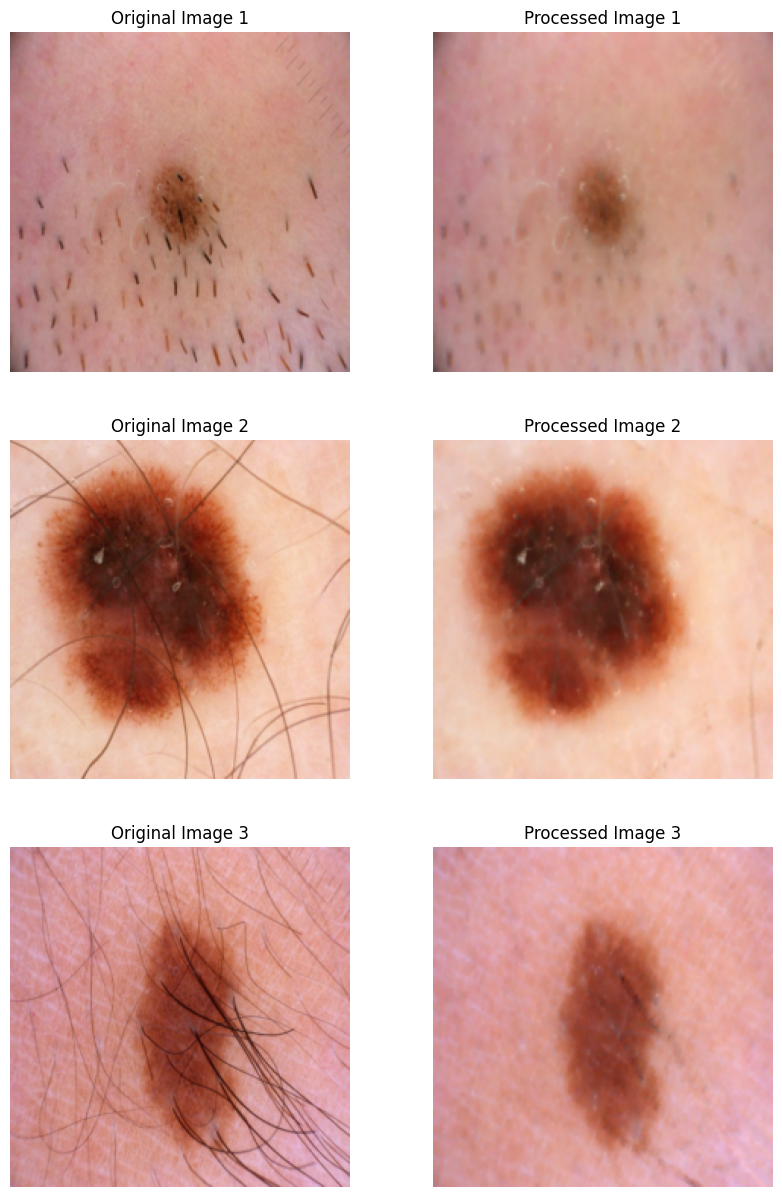

In [ ]:
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Ensure matplotlib inline mode
%matplotlib inline

csv_file_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_Input'
image_files_to_process = ['ISIC_0000102_downsampled', 'ISIC_0000103_downsampled', 'ISIC_0000115_downsampled']  # Replace with the image filenames you want to process, without the extension

# Load the CSV file
data = pd.read_csv(csv_file_path)

# Define a function to remove hair artifacts
def remove_hair(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply thresholding and Otsu's binarization
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Define a smaller kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    # Apply black hat top-hat transform
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    # Inpaint the image with a larger radius
    inpaint = cv2.inpaint(image, blackhat, 3, cv2.INPAINT_TELEA)
    return inpaint

# Define other preprocessing steps
def denoise_image(image):
    # Apply non-local means denoising
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

def color_correction(image):
    # Convert to LAB color space
    result = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(result)
    # Apply CLAHE for luminance correction
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    result = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return result

def illumination_correction(image):
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # Apply CLAHE for illumination correction
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    result = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return result

def contrast_enhancement(image):
    # Adjust contrast and brightness
    alpha = 1.2  # Contrast adjustment factor
    beta = -10   # Brightness adjustment factor
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def edge_enhancement(image):
    # Define a sharpening kernel
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define a function to process a single image
def process_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)

    # Apply preprocessing steps
    preprocessed_image = remove_hair(image_np)
    # preprocessed_image = denoise_image(preprocessed_image)
    # preprocessed_image = color_correction(preprocessed_image)
    # preprocessed_image = illumination_correction(preprocessed_image)
    # preprocessed_image = contrast_enhancement(preprocessed_image)
    # preprocessed_image = edge_enhancement(preprocessed_image)

    # Convert to tensor and normalize
    image_tensor = transform(Image.fromarray(preprocessed_image))

    return image_tensor

# Process multiple images and display the results
fig, axes = plt.subplots(len(image_files_to_process), 2, figsize=(10, 5 * len(image_files_to_process)))

for i, image_file in enumerate(image_files_to_process):
    img_path = os.path.join(image_folder_path, image_file + ".jpg")

    # Process the original image
    original_image = transform(Image.open(img_path).convert('RGB')).permute(1, 2, 0).numpy()
    original_image = original_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]

    # Process the preprocessed image
    processed_image_tensor = process_image(img_path)
    processed_image = processed_image_tensor.permute(1, 2, 0).numpy()
    processed_image = processed_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]

    # Display the images
    axes[i, 0].imshow(np.clip(original_image, 0, 1))
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(np.clip(processed_image, 0, 1))
    axes[i, 1].set_title(f'Processed Image {i+1}')
    axes[i, 1].axis('off')

plt.show()

By the way, we have also tried other methods to balance the dataset. Initially, we consulted with our tutor and were advised to standardize the number of instances for each category to 1000. However, doing so would have left us with only 8000 samples in total. We followed this approach, but after testing the models, we found that the accuracy was worse. We analyzed that this was due to the total number of samples being much less than in the original dataset.

Therefore, we adopted the following balancing scheme for the data: for categories with more than 5000 instances, we used undersampling to reduce their numbers to 80% of their original count; for categories with fewer than 2000 instances, we performed data augmentation to increase their numbers to exceed 2000. This approach allowed us to achieve a more balanced distribution while preserving a sufficient dataset size for effective model training and evaluation.


## **3.2 Processed Dataset**
The following code introduces additional data augmentation techniques to address class imbalance in the training dataset. It begins by importing necessary libraries and reading the CSV file containing image filenames and labels. The data is split into training, validation, and test sets with a 0.6:0.2:0.2 ratio, ensuring stratification based on labels. A custom augmentation transform, RandomRotate180, is defined to randomly rotate images, enhancing the diversity of the training data. Additional augmentations include random horizontal and vertical flips, resized crops, and contrast change.

Class balancing is achieved by resampling the training data, ensuring each class has between 2000 and 5000 samples. Classes with fewer samples are augmented, while those with excess samples are undersampled. The SkinDiseaseDataset class is used to load images and apply both augmentation and common transformations. The resulting datasets are loaded using DataLoader with batch processing to facilitate model training. The code concludes with label count checks for each dataset, verifying the effectiveness of the class balancing process.


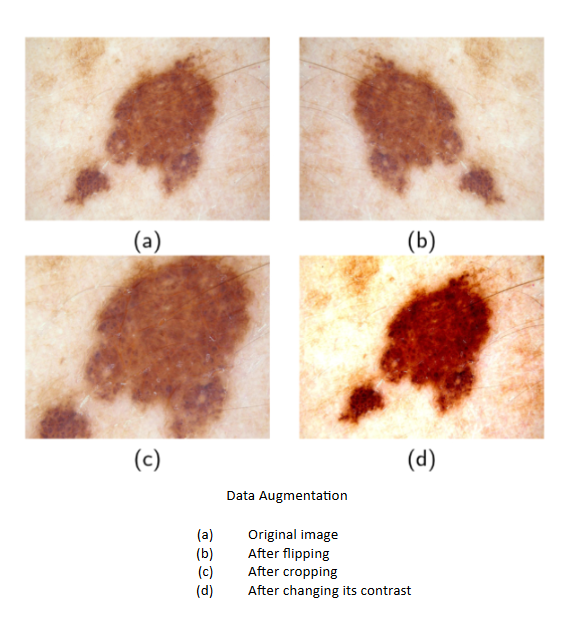

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify here
csv_file_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
data['label'] = data.drop(['image', 'UNK'], axis=1).idxmax(axis=1)
image_files = data['image'].values
labels = data['label'].values

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Split the training set into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['label'])

# Set minimum and maximum sample sizes
min_samples = 2000
max_samples = 5000

balanced_train_data = pd.DataFrame()

class RandomRotate180:
    def __call__(self, img):
        if random.random() > 0.5:
            return img.rotate(180)
        return img

# Augmentation transforms for training data
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomRotate180(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(contrast=(0.5, 1.5))
])

# Common transforms for all data
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for label in train_data['label'].unique():
    label_data = train_data[train_data['label'] == label]
    count = len(label_data)

    if count < min_samples:
        n_samples = min(max_samples, max(min_samples, count * 2))
        n_augment = n_samples - count

        augmented_data = []
        for _, row in label_data.iterrows():
            img_name = os.path.join(image_folder_path, row['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_data.append([row['image'], label])

        for i in range(n_augment):
            img_name = os.path.join(image_folder_path, label_data.iloc[i % count]['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_image = augmentation_transforms(image)
            augmented_image_name = f"{label_data.iloc[i % count]['image']}_augmented_{i}"
            augmented_image_path = os.path.join(image_folder_path, augmented_image_name + ".jpg")

            # Save the augmented image only if it doesn't already exist
            if not os.path.exists(augmented_image_path):
                augmented_image.save(augmented_image_path)

            augmented_data.append([augmented_image_name, label])

        augmented_df = pd.DataFrame(augmented_data, columns=['image', 'label'])
        label_data = pd.concat([label_data, augmented_df])

    elif count > max_samples:
        n_samples = max(min_samples, int(count * 0.8))
        label_data = resample(label_data, replace=False, n_samples=n_samples, random_state=42)

    balanced_train_data = pd.concat([balanced_train_data, label_data])

# Separate the image filenames and labels of the training set
train_images = balanced_train_data['image'].values
train_labels = pd.get_dummies(balanced_train_data['label']).values

# Separate the image filenames and labels of the validation set
val_images = val_data['image'].values
val_labels = pd.get_dummies(val_data['label']).values

# Separate the image filenames and labels of the test set
test_images = test_data['image'].values
test_labels = pd.get_dummies(test_data['label']).values

# Define the dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Image transformation for training data
train_transform = transforms.Compose([
    augmentation_transforms,
    common_transforms
])

# Create training, validation, and test datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir=image_folder_path, transform=train_transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir=image_folder_path, transform=common_transforms)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir=image_folder_path, transform=common_transforms)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Check if balanced
train_counts = balanced_train_data['label'].value_counts()
val_counts = val_data['label'].value_counts()
test_counts = test_data['label'].value_counts()

print("Training set label counts:")
print(train_counts)
print("\nValidation set label counts:")
print(val_counts)
print("\nTest set label counts:")
print(test_counts)


Training set label counts:
label
NV      6180
BCC     5982
BKL     4722
MEL     2714
AK      2520
SCC     2376
VASC    2152
DF      2143
Name: count, dtype: int64

Validation set label counts:
label
NV      2575
MEL      904
BCC      664
BKL      525
AK       174
SCC      126
VASC      50
DF        48
Name: count, dtype: int64

Test set label counts:
label
NV      2575
MEL      904
BCC      665
BKL      525
AK       173
SCC      126
VASC      51
DF        48
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Up to this point, we have obtained the original dataset that has been split and undergone simple preprocessing (resizing images to 224x224 pixels, converting images to tensor format, and normalization). Additionally, based on the original dataset, we have created a processed dataset that has been balanced for the training set (through undersampling and data augmentation). Next, we will use these two datasets for model training and compare the results.
